# Employee Performance 

In [1]:
import zipfile
import pandas as pd
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load data
zip_file_path = 'Employee Performance.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('extracted_data')

train_df = pd.read_csv('extracted_data/train_dataset.csv')
test_df = pd.read_csv('extracted_data/test_dataset.csv')

# Basic data checks and cleaning
print(train_df.head())
train_df = train_df.loc[:, ~train_df.columns.duplicated()]  # Remove duplicated columns
test_df = test_df.loc[:, ~test_df.columns.duplicated()]

# Impute missing values
imputer = KNNImputer(n_neighbors=3)  # KNN Imputer to handle missing data
train_df[['wip']] = imputer.fit_transform(train_df[['wip']])
test_df[['wip']] = imputer.transform(test_df[['wip']])

# Feature Scaling
scaler = StandardScaler()
continuous_columns = ['over_time', 'incentive', 'idle_time', 'wip', 'no_of_workers']
train_df[continuous_columns] = scaler.fit_transform(train_df[continuous_columns])
test_df[continuous_columns] = scaler.transform(test_df[continuous_columns])

# Feature Engineering
train_df['cumulative_productivity'] = train_df['actual_productivity'].cumsum()
train_df['rolling_productivity_mean'] = train_df['actual_productivity'].rolling(window=3).mean()
train_df['work_condition_index'] = train_df[['wip', 'over_time', 'incentive']].mean(axis=1)

# Features and target
X = train_df.drop(columns=['actual_productivity'])
y = train_df['actual_productivity']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

   team  targeted_productivity    smv    wip  over_time  incentive  idle_time  \
0     9                   0.75   3.94    NaN        960          0        0.0   
1     7                   0.65  30.10  909.0       7080          0        0.0   
2     3                   0.80   4.15    NaN       1440          0        0.0   
3     1                   0.65  22.53  762.0       5040          0        0.0   
4     4                   0.70  30.10  767.0       3300         50        0.0   

   idle_men  no_of_style_change  no_of_workers  ...  department_finishing  \
0         0                   0            8.0  ...                     1   
1         0                   1           59.0  ...                     0   
2         0                   0            7.0  ...                     0   
3         0                   1           42.0  ...                     0   
4         0                   1           57.0  ...                     0   

   department_finishing   department_sweing  day_M

In [3]:
# Hyperparameter Tuning for Random Forest and XGBoost using GridSearchCV
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_model = RandomForestRegressor(random_state=42)
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=3, n_jobs=-1, verbose=2)

xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=xgb_param_grid, n_iter=50, cv=3, n_jobs=-1, verbose=2)

# Fit the GridSearch and RandomizedSearch models
print("Fitting Random Forest GridSearch...")
rf_grid_search.fit(X_train, y_train)  # Make sure to fit before accessing best estimator
print("Fitting XGBoost RandomizedSearch...")
xgb_random_search.fit(X_train, y_train)  # Make sure to fit before accessing best estimator

# Evaluating models with GridSearch and RandomizedSearch
def train_and_evaluate(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    print(f"Model: {model.__class__.__name__}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R-Squared (R²): {r2:.4f}")
    print("="*40)

# Train and evaluate models
print("\nEvaluating Random Forest model...")
train_and_evaluate(rf_grid_search.best_estimator_, X_train, y_train, X_val, y_val)
print("\nEvaluating XGBoost model...")
train_and_evaluate(xgb_random_search.best_estimator_, X_train, y_train, X_val, y_val)

Fitting Random Forest GridSearch...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Fitting XGBoost RandomizedSearch...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

Evaluating Random Forest model...
Model: RandomForestRegressor
Mean Absolute Error (MAE): 0.0839
Mean Squared Error (MSE): 0.0165
R-Squared (R²): 0.5017

Evaluating XGBoost model...
Model: XGBRegressor
Mean Absolute Error (MAE): 0.0860
Mean Squared Error (MSE): 0.0167
R-Squared (R²): 0.4984


Test Predictions: [0.7255861  0.7306825  0.44191003 0.48331976 0.5163476  0.5010702
 0.4405099  0.5560413  0.5115362  0.49229553]


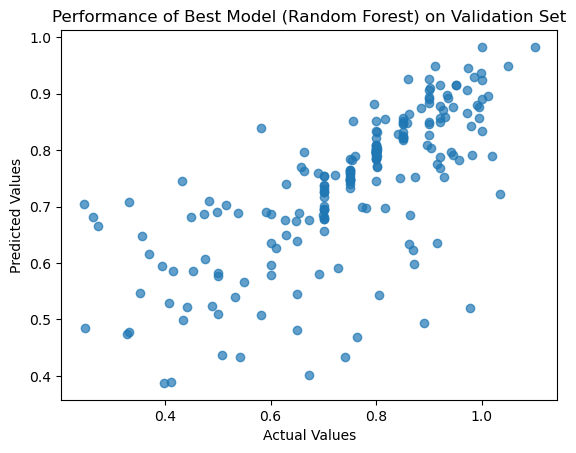

In [4]:
# Test set evaluation

# Step 1: Apply feature engineering on the test data (same as training set)
# Don't use 'actual_productivity' in test data for feature engineering
test_df['cumulative_productivity'] = test_df['wip'].cumsum()  # Just an example, adjust as needed
test_df['rolling_productivity_mean'] = test_df['wip'].rolling(window=3).mean()  # Example
test_df['work_condition_index'] = test_df[['wip', 'over_time', 'incentive']].mean(axis=1)

# Step 2: Ensure the test set has the same columns as the training set (drop columns that are not in the training set)
test_df = test_df[X.columns]  # Align the columns of the test set with the training set

# Step 3: Apply scaling to the test set (use the scaler fitted on the training data)
test_df[continuous_columns] = scaler.transform(test_df[continuous_columns])

# Step 4: Make predictions using the best XGBoost model
test_predictions = xgb_random_search.best_estimator_.predict(test_df)

# Step 5: Display the first 10 predictions
print(f"Test Predictions: {test_predictions[:10]}")

# Step 6: Visualize results for validation set (Optional)
plt.scatter(y_val, rf_grid_search.best_estimator_.predict(X_val), alpha=0.7)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Performance of Best Model (Random Forest) on Validation Set")
plt.show()